In [1]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from pandas import DataFrame, Series, read_csv, to_datetime, concat

In [2]:
def remove_points(item):
    return ':'.join(item.split(':')[:-1:])


def parse_float(item):
    return float(item.split('=')[-1])


def clean_or_none(item, action):
    try:
        return action(item)
    except Exception as e:
        print(e)
        return None


def translate_datetime(data):
    data.time = [to_datetime('%s %s' % (date, time), format='%Y-%m-%d %H:%M:%S') for date, time in zip(data.date, data.time)]
    
    
def process_data(data):
    for i, row in data.iterrows():
        row.time = clean_or_none(row.time, lambda arg: ':'.join(arg.split(':')[:-1:]))
        row.time = to_datetime('%s %s' % (row.date, row.time), format='%Y-%m-%d %H:%M:%S')
        row.ip = clean_or_none(row.ip, lambda arg: arg.split(':')[0])
        row.ttl = clean_or_none(row.ttl, lambda arg: int(arg.split('=')[-1]))
        row.ping = clean_or_none(row.ping, lambda arg: float(arg.split('=')[-1]))
    return data.drop(columns=['date'])
        

data = read_csv('pinger.log', sep=' ', skiprows=[0], header=None)

data = data.drop(columns=[3, 4, 6, 9])
data.columns = ['date', 'time', 'bytes', 'ip', 'ttl', 'ping']

#%%timeit
mark_errors_none(data, 'time', lambda item: ':'.join(item.split(':')[:-1:]))
mark_errors_none(data, 'ip', lambda item: item.split(':')[0])
mark_errors_none(data, 'ttl', lambda item: int(item.split('=')[-1]))
mark_errors_none(data, 'ping', lambda item: item.split('=')[-1])

In [3]:
data = process_data(data)
data = data.dropna()

invalid literal for int() with base 10: 'Unreachable'
'float' object has no attribute 'split'
invalid literal for int() with base 10: 'of'
could not convert string to float: 'data.'


In [4]:
# clear anomalies
data = data.drop(data[data.ping > 1000].index)

In [5]:
from pandas import DatetimeIndex, Period
data.time = DatetimeIndex(data.time)

In [6]:
value_avg = lambda val: round(sum(val) / len(val), 2)
value_max = lambda val: max(val)
value_min = lambda val: min(val)

ping_by_hour = lambda row: (row.time.hour, row.ping)
ping_by_weekday = lambda row: (row.time.day_name(), row.ping)
ping_by_date_hour = lambda row: (row.time.strftime('%Y-%m-%d %H'), row.ping)

In [7]:
def get_statistics(data, by, resolver, calc):
    buff = {key: [] for key in by}
    
    for i, row in data.iterrows():
        key, val = resolver(row)
        try:
            buff[key].append(val)
        except Exception as e:
            print(key, val, buff[key])
        
    for key, val in buff.items():
        buff[key] = calc(0 if len(val) == 0 else val)
        
    return stat


def get_mma_stat(data, by, resolver, index_name='time'):
    buff = {key: [] for key in by}
    stat = {
        index_name: [],
        'min': [],
        'max': [],
        'avg': []
    }
    
    for i, row in data.iterrows():
        key, val = resolver(row)
        try:
            buff[key].append(val)
        except Exception as e:
            print(key, val, buff[key])
        
    for key, val in buff.items():
        stat[index_name].append(key)
        stat['min'].append(value_min(val))
        stat['max'].append(value_max(val))
        stat['avg'].append(value_avg(val))
        
    return DataFrame(stat)

In [8]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hours = [hour for hour in range(24)]
date_hours = [time for time in np.unique(data.time.dt.strftime('%Y-%m-%d %H'))]

def get_ping_hour_average(data):
    return get_statistics(data, hours, ping_by_hour, value_avg)


def get_ping_hour_max(data):
    return get_statistics(data, hours, ping_by_hour, value_max)


def get_ping_hour_min(data):
    return get_statistics(data, hours, ping_by_hour, value_min)


def get_ping_weekday_average(data):
    return get_statistics(data, weekdays, ping_by_weekday, value_avg)


def get_ping_weekday_max(data):
    return get_statistics(data, weekdays, ping_by_weekday, value_max)


def get_ping_weekday_min(data):
    return get_statistics(data, weekdays, ping_by_weekday, value_min)

In [9]:
ping_hour_stat = get_mma_stat(data, hours, ping_by_hour, index_name='hours')

In [10]:
ping_weekday_stat = get_mma_stat(data, weekdays, ping_by_weekday, index_name='day')

In [11]:
ping_date_hours_stat = get_mma_stat(data, date_hours, ping_by_date_hour)

In [12]:
ping_hour_stat

,hours,min,max,avg
0,0,9.54,43.6,11.31
1,1,9.56,42.3,11.06
2,2,9.59,54.3,11.13
3,3,9.59,35.5,11.25
4,4,9.50,69.2,11.11
5,5,9.51,42.7,11.09
6,6,9.55,40.5,10.92
7,7,9.57,31.5,10.87
8,8,9.54,24.5,10.88
9,9,9.58,40.4,10.92


In [13]:
ping_weekday_stat

,day,min,max,avg
0,Monday,10.00,65.2,11.09
1,Tuesday,9.69,130.0,10.99
2,Wednesday,10.30,39.4,11.11
3,Thursday,9.55,62.9,12.40
4,Friday,9.50,69.2,11.18
5,Saturday,10.30,54.3,11.48
6,Sunday,10.30,46.9,11.45


In [14]:
ping_date_hours_stat

,time,min,max,avg
0,2022-12-19 06,10.1,12.0,10.80
1,2022-12-19 07,10.1,15.4,10.71
2,2022-12-19 08,10.0,12.2,10.62
3,2022-12-19 09,10.1,17.3,10.80
4,2022-12-19 10,10.0,14.6,10.72
...,...,...,...,...
164,2022-12-26 11,10.5,15.1,11.16
165,2022-12-26 12,10.5,13.9,11.14
166,2022-12-26 13,10.3,13.2,11.14
167,2022-12-26 14,10.4,13.3,11.12


<IPython.core.display.Javascript object>


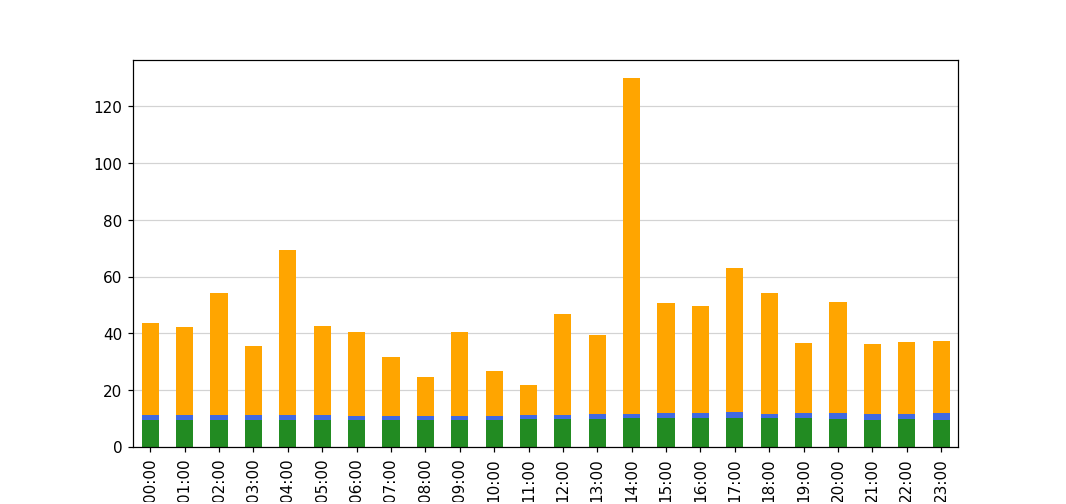

<IPython.core.display.Javascript object>


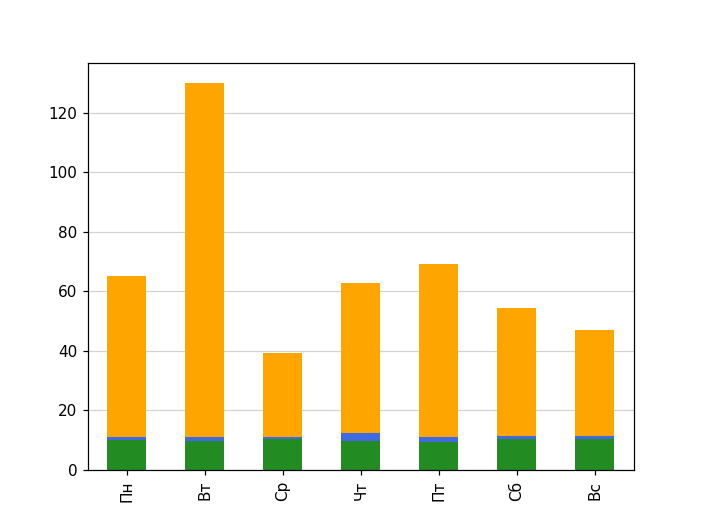

<IPython.core.display.Javascript object>


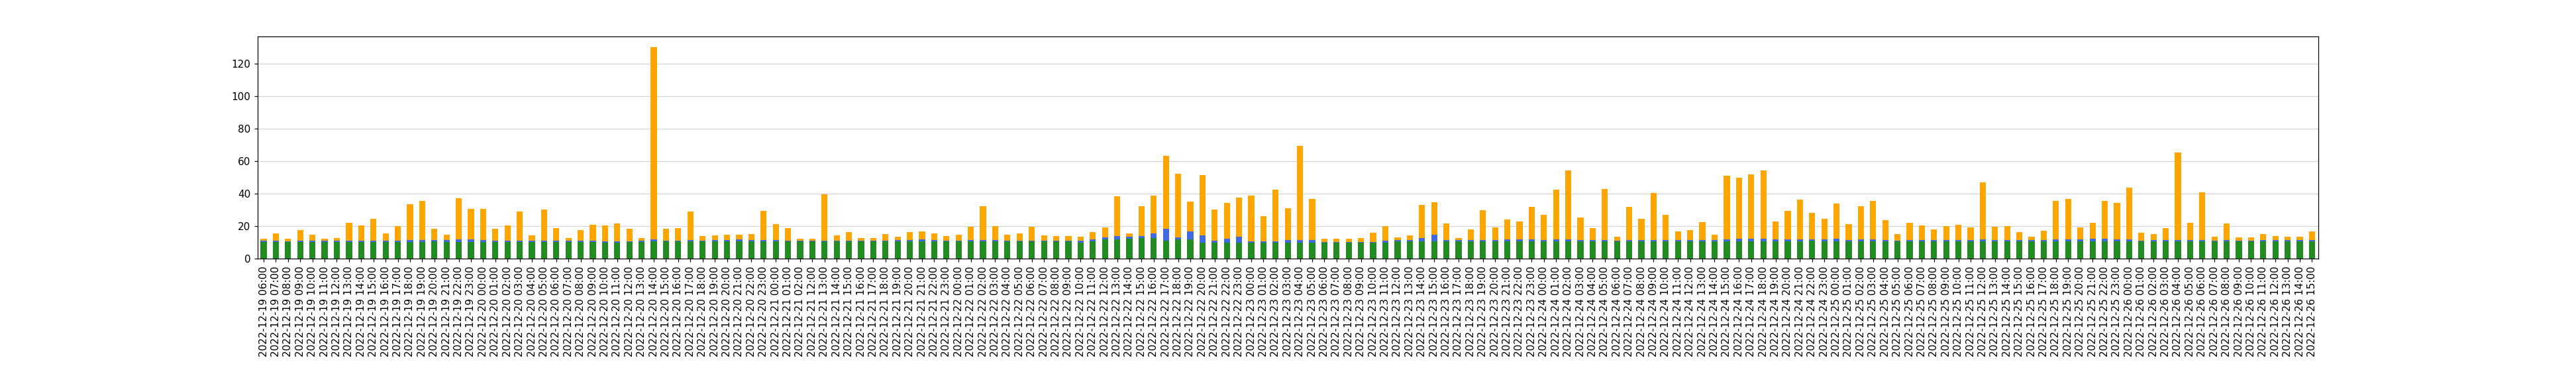

In [21]:
colors = {'min': 'forestgreen',
          'max': 'orange',
          'avg': 'royalblue',
          'grid': 'lightgray',
          'background': 'white'}

hours_labels = ['%s:00' % str(hour).rjust(2, '0') for hour in range(len(ping_hour_stat))]
weekdays_labels_en = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekdays_labels_ru = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
date_hours_labels = ['%s:00' % time for time in date_hours]
weekdays_labels = weekdays_labels_ru

def make_pretty(ax):
    ax.grid(True, color=colors['grid'], axis='y')
    ax.figure.set_facecolor(colors['background'])
    ax.patch.set_alpha(0)
    ax.set_axisbelow(True)
    return ax
    
def plot_mma_bar(ax, data, labels, kind='bar'):
    data['max'].plot(ax=ax, kind=kind, color=colors['max'])
    ax.set_xticks(ticks=[], labels=[])
    
    data['avg'].plot(ax=ax, kind=kind, color=colors['avg'])
    ax.set_xticks(ticks=[], labels=[])
    
    data['min'].plot(ax=ax, kind=kind, color=colors['min'])
    ax.set_xticks(ticks=data.index, labels=labels, rotation='vertical')
    
    make_pretty(ax)
    
#     return make_pretty(ax)

fig_hours, ax_hours = plt.subplots()
fig_weekdays, ax_weekdays = plt.subplots()
fig_date_hours, ax_date_hours = plt.subplots()

fig_date_hours.subplots_adjust(**{
    'top': 0.9,
    'bottom': 0.3,
    'left': 0.1,
    'right': 0.9
})

plot_mma_bar(ax_hours, ping_hour_stat, hours_labels, kind='bar')
plot_mma_bar(ax_weekdays, ping_weekday_stat, weekdays_labels, kind='bar')
plot_mma_bar(ax_date_hours, ping_date_hours_stat, date_hours_labels, kind='bar')

In [ ]:
time = to_datetime('2023-12-01 22:30')

In [ ]:
dates = (date.strftime('%d.%m.%Y %H') for date in data.time.dt.date)
[date for date in dates]

In [ ]:
d = {i: {'min': i, 'max': i*10, 'avg': i*10} for i in range(11)}
df = DataFrame(d, columns=['min', 'max', 'avg'])

In [ ]:
df